In [56]:
using Pkg
Pkg.activate("..")
using Revise
using Gen
using DataFrames
using Logging
using StatsPlots
using Statistics

  Activating project at `~/src/mit/BayesAir.jl`


In [57]:
using BayesAir

In [11]:
global_logger(ConsoleLogger(stderr, Logging.Info));

In [120]:
# Hyperparams
top_N = 6

# Load data and preprocess
df = BayesAir.load_all_data()
df = BayesAir.remap_columns(df)
filtered_df = BayesAir.top_N_df(df, top_N)
nominal_df, disrupted_df = BayesAir.split_nominal_disrupted_data(filtered_df)
nominal_dfs = BayesAir.split_by_date(nominal_df)
disrupted_dfs = BayesAir.split_by_date(disrupted_df)

println("Top-", top_N, " network has airports: ", unique(filtered_df[!, :destination]))
println("Top-", top_N, " network had " , size(nominal_dfs[1], 1), " flights on day 1")

Top-6 network has airports: InlineStrings.String3["MDW", "LAS", "BWI", "DAL", "PHX", "DEN"]
Top-6 network had 197 flights on day 1


In [121]:
# Load the nominal days into a schedule object
days = 1
starting_aircraft = 100
states = Vector{BayesAir.NetworkState}()
for i in 1:days
    flights, airports = BayesAir.parse_schedule(nominal_dfs[i] |> DataFrame)

    for _ in 1:starting_aircraft
        for airport_idx in 1:length(airports)
            push!(airports[airport_idx].available_aircraft, 0.0)
            push!(airports[airport_idx].available_crew, 0.0)
        end
    end

    airport_dict = Dict{String, BayesAir.Airport}()
    for airport in airports
        airport_dict[airport.code] = airport
    end

    state = BayesAir.NetworkState(airport_dict, flights |> Vector{BayesAir.Flight})
    push!(states, state)
end
nominal_dfs[1][1:10, :]

10×8 DataFrame
 Row │ destination  scheduled_arrival_time  actual_departure_time  scheduled_d ⋯
     │ String3      Float64                 Float64                Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ MDW                         8.33333                4.98333              ⋯
   2 │ DAL                         8.25                   5.26667
   3 │ PHX                         8.25                   5.18333
   4 │ PHX                         7.41667                5.28333
   5 │ DEN                         8.25                   5.26667              ⋯
   6 │ MDW                        10.8333                 5.36667
   7 │ DAL                         8.75                   5.38333
   8 │ DEN                         7.25                   5.4
   9 │ BWI                        10.9167                 5.5                  ⋯
  10 │ DAL                        10.0833                 5.5
                                                               5 columns omitted

In [122]:
test_df = nominal_dfs[1]
# Compute the mean difference between actual arrival and departure times for each origin-destination pair
test_df[!, :actual_travel_time] = test_df[!, :actual_arrival_time] - test_df[!, :actual_departure_time]
mean_actual_travel_times = combine(groupby(test_df, [:origin, :destination]), :actual_travel_time => mean)
# Sort by origin-destination pair
sort!(mean_actual_travel_times, [:origin, :destination])

30×3 DataFrame
 Row │ origin   destination  actual_travel_time_mean 
     │ String3  String3      Float64                 
─────┼───────────────────────────────────────────────
   1 │ BWI      DAL                         2.275
   2 │ BWI      DEN                         1.85833
   3 │ BWI      LAS                         2.31667
   4 │ BWI      MDW                         0.945833
   5 │ BWI      PHX                         3.16667
   6 │ DAL      BWI                         3.51667
   7 │ DAL      DEN                         1.0037
   8 │ DAL      LAS                         0.997619
  ⋮  │    ⋮          ⋮                  ⋮
  24 │ MDW      LAS                         2.08611
  25 │ MDW      PHX                         2.89444
  26 │ PHX      BWI                         5.95
  27 │ PHX      DAL                         3.00833
  28 │ PHX      DEN                         1.5697
  29 │ PHX      LAS                         4.48333
  30 │ PHX      MDW                         3.99167
                                      15 rows omitted

In [106]:
function render_traces(traces)
    # For each pair of airports, make a scatter plot of the travel times for each trace
    airport_codes = keys(Gen.get_args(traces[1])[1][1].airports)

    # Aggregate the travel times for each airport pair
    travel_times = Dict{Tuple{String, String}, Vector{Float64}}()
    for origin in airport_codes
        for destination in airport_codes
            if origin != destination
                travel_times[(origin, destination)] = Vector{Float64}()
            end
        end
    end
    for trace in traces
        for origin in airport_codes
            for destination in airport_codes
                if origin != destination
                    push!(travel_times[(origin, destination)], trace[(origin, destination, :travel_time)])
                end
            end
        end
    end

    already_plotted = Set{Tuple{String, String}}()
    figs = Vector{Plots.Plot{Plots.GRBackend}}()
    for (origin, destination) in keys(travel_times)
        if (origin, destination) in already_plotted
            continue
        end
        
        # Plot the estimated travel time distribution
        fig = marginalkde(
            travel_times[(origin, destination)],
            travel_times[(destination, origin)];
            xlabel=origin * " -> " * destination,
            ylabel=destination * " -> " * origin,
            legend=false,
        )
        
        # Plot the observed mean travel time
        travel_time_origin_destination = mean_actual_travel_times[
            (mean_actual_travel_times.origin .== origin) .& (mean_actual_travel_times.destination .== destination),
            :actual_travel_time_mean
        ]
        travel_time_destination_origin = mean_actual_travel_times[
            (mean_actual_travel_times.origin .== destination) .& (mean_actual_travel_times.destination .== origin),
            :actual_travel_time_mean
        ]
        scatter!(
            fig[2],
            [travel_time_origin_destination],
            [travel_time_destination_origin];
            marker=:star,
            markersize=10,
            color=:red,
            legend=false,
        )

        # Adjust the axis limits
        xlims!(fig[1], (0, 10.0))
        xlims!(fig[2], (0, 10.0))
        ylims!(fig[2], (0, 10.0))
        ylims!(fig[3], (0, 10.0))

        push!(already_plotted, (origin, destination))
        push!(already_plotted, (destination, origin))
        push!(figs, fig)
    end

    return figs
end;

In [127]:
@time trace = Gen.simulate(BayesAir.simulate, (states, 24.0, 0.2))
Gen.get_choices(trace);

  0.005839 seconds (63.62 k allocations: 2.105 MiB)


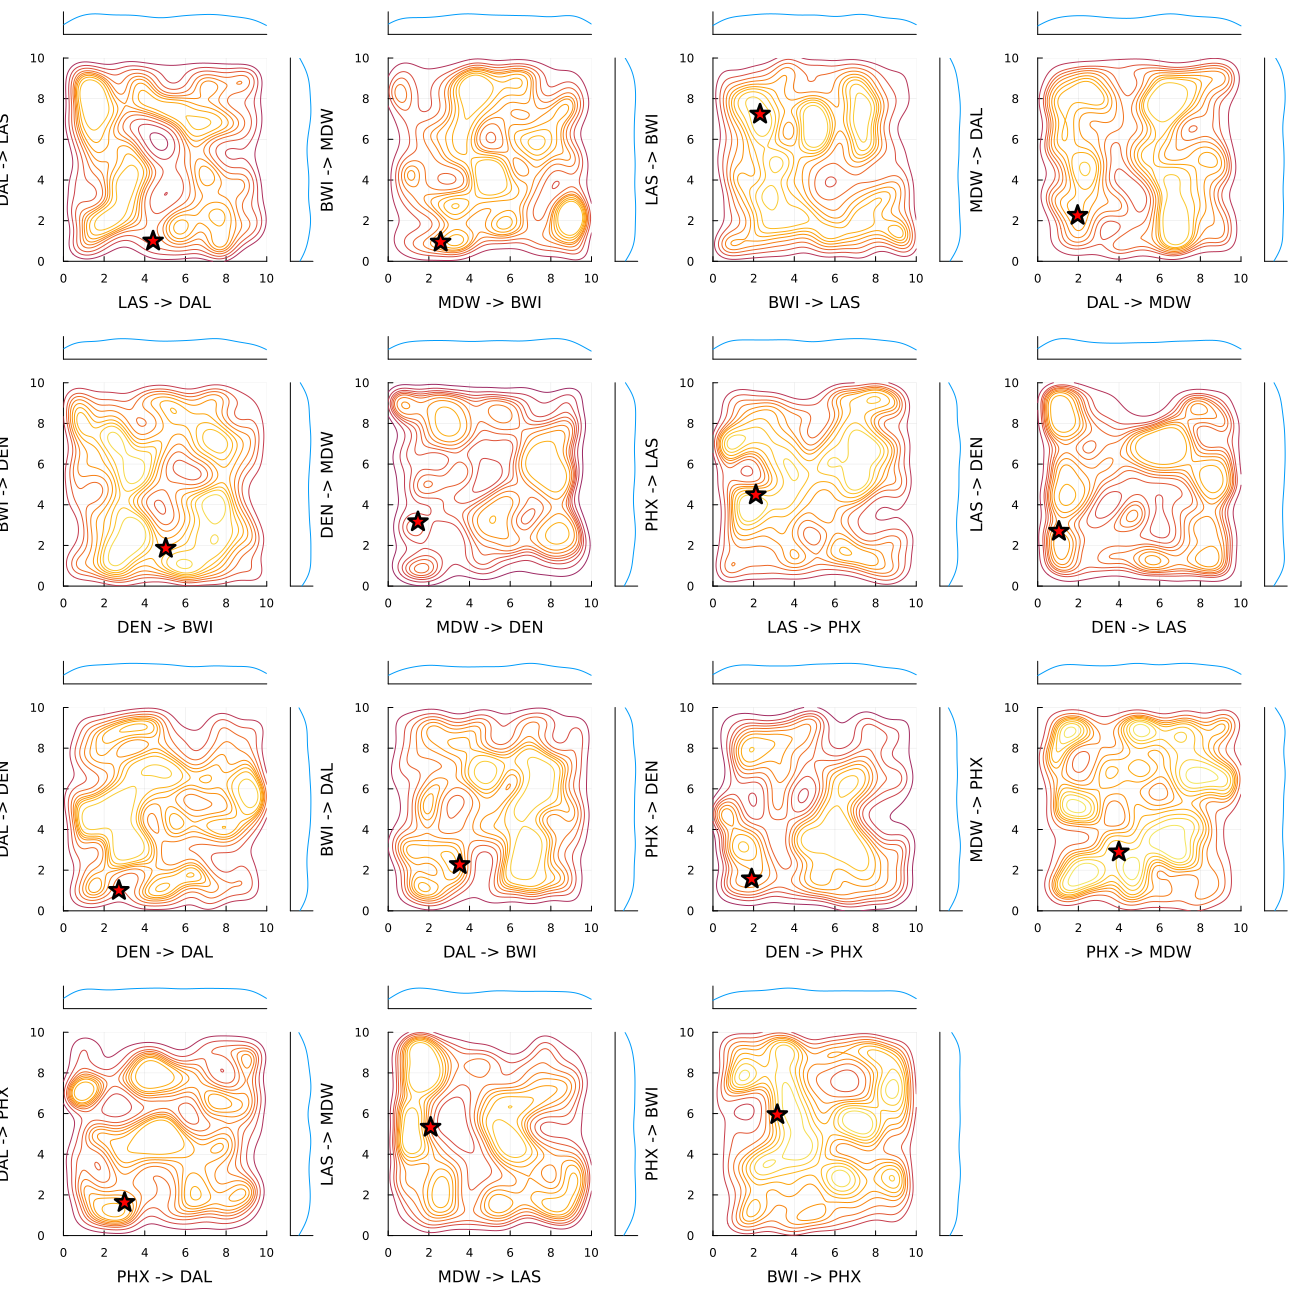

In [132]:
# Render the prior distribution
traces = [Gen.simulate(BayesAir.simulate, (states, 24.0, 0.2)) for _ in 1:100]
Plots.plot(render_traces(traces)..., size=(1300, 1300))

In [133]:
@gen function airport_parameter_proposal(trace, airport_code::BayesAir.AirportCode, width)
    # Resample the parameters for the given airport
    {(airport_code, :turnaround_time)} ~ uniform(
        max(0.0, trace[(airport_code, :turnaround_time)] - width / 2),
        trace[(airport_code, :turnaround_time)] + width / 2
    )
    {(airport_code, :service_time)} ~ uniform(
        max(0.0, trace[(airport_code, :service_time)] - width / 2),
        trace[(airport_code, :service_time)] + width / 2
    )
end

@gen function all_airport_parameter_proposal(trace, airport_codes, width)
    # Update turnaround time variation
    {:turnaround_time_variation} ~ uniform(
        max(0.0, trace[:turnaround_time_variation] - width / 2),
        trace[:turnaround_time_variation] + width / 2
    )

    # Update all airport params
    for airport_code in airport_codes
        {*} ~ airport_parameter_proposal(trace, airport_code, width)
    end
end

@gen function travel_times_proposal(trace, airport_codes, width)
    # Resample travel time and measurement variation
    {:travel_time_variation} ~ uniform(
        max(0.0, trace[:travel_time_variation] - width / 2),
        trace[:travel_time_variation] + width / 2
    )
    {:measurement_variation} ~ uniform(
        max(0.0, trace[:measurement_variation] - width / 2),
        trace[:measurement_variation] + width / 2
    )

    # Update the mean travel times for all routes
    for origin_code in airport_codes
        for destination_code in airport_codes
            if origin_code != destination_code
                key = (origin_code, destination_code, :travel_time)
                {key} ~ uniform(
                    max(0.0, trace[key] - width / 2),
                    min(trace[key] + width / 2, 10.0)
                )
            end
        end
    end
end

@gen function all_parameters_proposal(trace, airport_codes, width)
    {*} ~ all_airport_parameter_proposal(trace, airport_codes, width)
    {*} ~ travel_times_proposal(trace, airport_codes, width)
end

function drift_update(trace, width, constraints)
    airport_codes = keys(Gen.get_args(trace)[1][1].airports)
    (trace, all_accepted) = mh(trace, all_parameters_proposal, (airport_codes, width), check=true, observations=constraints)

    return trace, Dict(
        :all => all_accepted
    )
end;

function resimulation_update(trace, width, constraints)
    # Select everything other than observations and resimulate
    observations = Vector{Any}()
    for (i, state) in enumerate(states)
        for flight in state.pending_flights
            push!(observations, (:day, i) => (BayesAir.flight_code(flight), :actual_departure_time))
            push!(observations, (:day, i) => (BayesAir.flight_code(flight), :actual_arrival_time))
        end
    end
    (trace, complement_accepted) = mh(trace, Gen.complement(Gen.select(observations...)), check=true, observations=constraints)

    return trace, Dict(
        :complement => complement_accepted,
    )
end;

function do_mcmc_inference(model, states, hrs, dt, num_samples, burn_in_samples, width)
    # Make constraints based on actual departure and arrival times
    constraints = Gen.choicemap()
    for (i, state) in enumerate(states)
        for flight in state.pending_flights
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_departure_time)] = flight.actual_departure_time
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_arrival_time)] = flight.actual_arrival_time
        end
    end

    # Get an initial trace
    (trace, _) = Gen.generate(model, (states, hrs, dt), constraints)

    # Run the burn-in
    for _ in 1:burn_in_samples
        trace, _ = drift_update(trace, width, constraints)
    end

    # Run the main loop
    scores = Vector{Float64}()
    traces = Vector{Gen.DynamicDSLTrace}()
    acceptance_rates = Dict()
    for _ in 1:num_samples
        trace, accepted = drift_update(trace, width, constraints)
        push!(traces, trace)
        push!(scores, Gen.get_score(trace))

        # Update acceptance rates
        for (key, value) in accepted
            if !haskey(acceptance_rates, key)
                acceptance_rates[key] = 0.0
            end

            acceptance_rates[key] = acceptance_rates[key] + value / num_samples
        end
    end

    return traces, scores, acceptance_rates
end;

average_acceptance_rates = Dict{Any, Any}(:all => 0.1830000000000001)


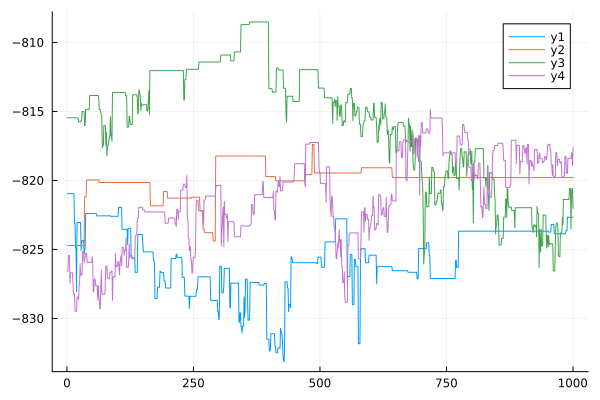

In [136]:
all_traces = Vector{Any}()
trace_figs = Vector{Plots.Plot{Plots.GRBackend}}()
scores = Vector{Vector{Float64}}()
average_acceptance_rates = Dict()
n_chains = 4
stepsize = 0.1
burn_in_samples = 50_000
samples = 1_000
n_hours = 30.0
dt = 0.2
for _ in 1:n_chains
    traces, trace_scores, acceptance_rates = do_mcmc_inference(BayesAir.simulate, states, n_hours, dt, samples, burn_in_samples, stepsize)
    push!(all_traces, traces)
    push!(scores, trace_scores)
    for (key, value) in acceptance_rates
        if !haskey(average_acceptance_rates, key)
            average_acceptance_rates[key] = 0.0
        end
        average_acceptance_rates[key] = average_acceptance_rates[key] + value / n_chains
    end
end
@show average_acceptance_rates
Plots.plot([s for s in scores])

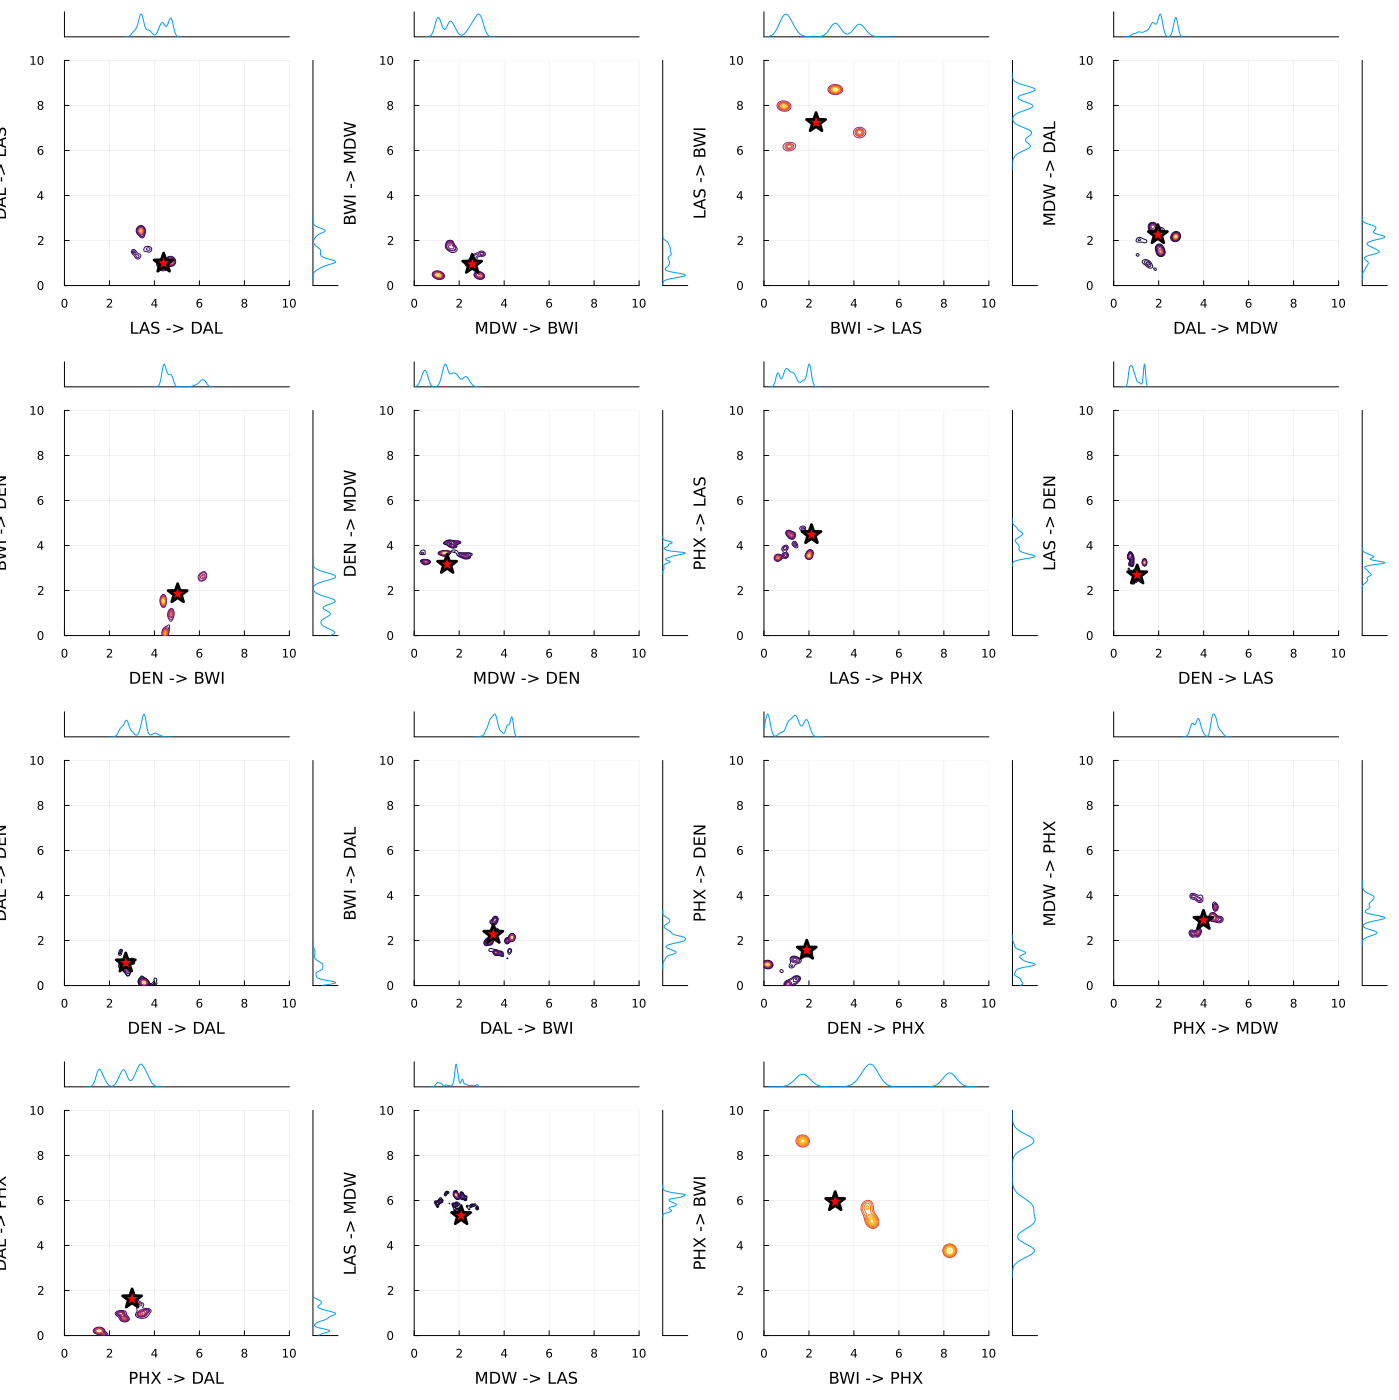

In [137]:
Plots.plot(render_traces(vcat(all_traces...))..., size=(1400, 1400))